## Choosing hyperparameters for ViCTORIA

In this notebook, we are trying different numbers of SE-ResNet blocks for our final model.

In [1]:
import sys
sys.path.insert(1, "lib/")
sys.path.insert(1, "model/")
from ViCTORIA_network import ViCTORIA_Network, coeff_determination
from dataset_utils import read_many_hdf5

import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import platform
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

if tf.test.gpu_device_name(): 
  print(f"Default GPU Device: {tf.test.gpu_device_name()}")

Default GPU Device: /device:GPU:0


We are loading our training dataset and we are using it to build different training and validation data
for each model.

In [2]:
directory = "E:/IA/Deep_ViCTORIA/Datasets/SE_ResNet/"
positions, scores = read_many_hdf5(397182, directory, "_train")
positions = positions[:130000]
scores = scores[:130000]

nb_models = 4
positions_train, scores_train = [], []
positions_valid, scores_valid = [], []
for i in range(nb_models):
  positions_train_t, positions_valid_t, scores_train_t, scores_valid_t = train_test_split(
    positions, scores, test_size=0.2, random_state=42+i)
  positions_train.append(positions_train_t)
  positions_valid.append(positions_valid_t)
  scores_train.append(scores_train_t)
  scores_valid.append(scores_valid_t)
print(f"Training sets shape ≈ {positions_train[0].shape}, Validation sets shape ≈ {positions_valid[0].shape}")


Training sets shape ≈ (104000, 8, 8, 15), Validation sets shape ≈ (26000, 8, 8, 15)


Now, we create several models with an increasing number of SE-ResNet blocks.

In [3]:
models = []
offset_blocks = 2
for i in range(1, nb_models+1):
  model = ViCTORIA_Network(filters=64, nb_blocks=i+offset_blocks)
  model.build((1, 8, 8, 15))
  model.compile(loss='mean_absolute_error', optimizer="adam", metrics=[coeff_determination])
  models.append(model)
models[0].summary()

Model: "ViCTORIA"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1024      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 se__res_net_block (SE_ResNe  multiple                 9412      
 tBlock)                                                         
                                                                 
 se__res_net_block_1 (SE_Res  multiple                 9412      
 NetBlock)                                                       
                                                                 
 se__res_net_block_2 (SE_Res  multiple                 9412      
 NetBlock)                                                

We train our models.

In [4]:
nb_epochs = 20
histories = []
for i, model in enumerate(models):
  print(f"Model {i+1}/{len(models)}...", end=" ")
  history = model.fit(positions_train[i], scores_train[i], verbose=0, epochs=nb_epochs)
  histories.append(history)
  print("Done.")

Model 1/4... Done.
Model 2/4... Done.
Model 3/4... Done.
Model 4/4... Done.


In [19]:
def plot_validation_results(histories, validation_Xs, validation_ys, path=None, ext="pdf"):
  epochs = range(1, nb_epochs + 1)

  f, axs = plt.subplots(1, 2, figsize=(20, 5))
  _, ax_score  = plt.subplots(1, 1, figsize=(10, 5))

  line_styles = ["-","--","-.",":"]

  for i, history in enumerate(histories):
    X_valid = validation_Xs[i]
    y_valid = validation_ys[i]

    loss = history.history["loss"]
    score = history.history["coeff_determination"]
    axs[0].plot(epochs, loss, line_styles[i], label=f"{i + offset_blocks + 1} SE-ResNet blocks")

    axs[1].plot(epochs, score, line_styles[i], label=f"{i + offset_blocks + 1} SE-ResNet blocks")

    preds = models[i].predict(X_valid)
    r2_score = coeff_determination(tf.convert_to_tensor(y_valid), preds).numpy()
    ax_score.scatter(y_valid, preds, label = f"{i + offset_blocks + 1} SE-ResNet blocks $R^2 = {r2_score:.2f}$")


  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("(Mean Absolute Error)")
  axs[0].set_title('Training loss')
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("($R^2$)")
  axs[1].set_title('Training score')
  ax_score.set_xlabel("True values (centipawn)")
  ax_score.set_ylabel("Predictions (centipawn)")
  ax_score.set_title("Results on validation set")

  if path:
    f.savefig(path + "_1." + ext)

  ma = np.max(y_valid)
  mi = np.min(y_valid)
  x = np.linspace(ma, mi, 100)
  ax_score.plot(x, x, "-.", label = "Predictions = True values")
  ax_score.legend()
  for ax in axs:
    ax.legend()
  
  if path:
    plt.savefig(path + "_2." + ext)

def get_best_model(models, validation_Xs, validation_ys):
  preds = []
  for i in range(len(models)):
    pred = models[i].predict(validation_Xs[i])
    r2_score = coeff_determination(tf.convert_to_tensor(validation_ys[i]), pred).numpy()
    preds.append(r2_score)
  idx = np.argmax(preds)
  return models[idx]

Here are the results!

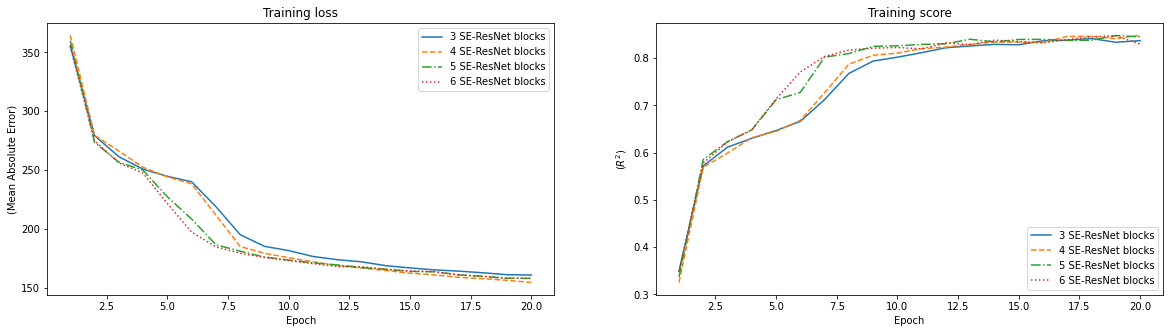

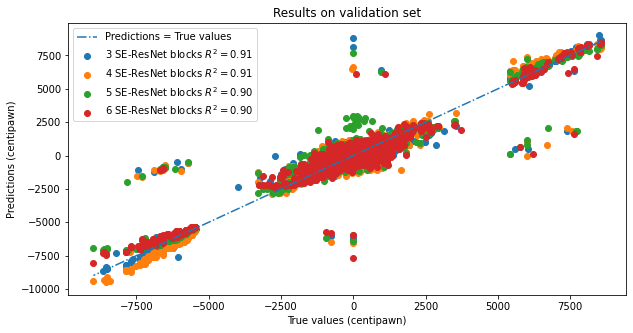

In [20]:
plot_validation_results(histories, positions_valid, scores_valid, path="results/model_selection")

We can see that all of our model perform well.  We pick the one that have the best score.

In [7]:
model = get_best_model(models, positions_valid, scores_valid)

We save the hyperparameters of our model in order to train it with more data and epochs in the future.

In [12]:
config = {"nb_blocks": model.nb_blocks, "filters": model.filters}
print(config)
output_file = open("model/hyperparameters.pickle", "wb")
pickle.dump(config, output_file)
output_file.close()

{'nb_blocks': 4, 'filters': 64}
